In [1]:
# ! pip install --upgrade tensorflow==2.16.1
# ! pip install --upgrade keras

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from joblib import dump, load
import pickle

In [4]:
print(tf.__version__)

2.10.0


In [6]:
data = pd.read_csv("convert_numeric.csv", delimiter=",")

In [7]:
data.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,gender,marital_status,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,0,6,1,3,1169,4,1,4,1,3,...,2,67,1,1,2,1,1,1,1,1
1,2,48,3,3,5951,0,2,2,0,1,...,2,22,1,1,1,1,1,0,1,0
2,3,12,1,9,2096,0,3,2,1,3,...,2,49,1,1,1,3,2,0,1,1
3,0,42,3,7,7882,0,3,2,1,3,...,0,45,1,0,1,1,2,0,1,1
4,0,24,2,1,4870,0,2,3,1,3,...,3,53,1,0,2,1,2,0,1,0


In [8]:
X = data.drop('credit_risk', axis=1)
y = data['credit_risk']

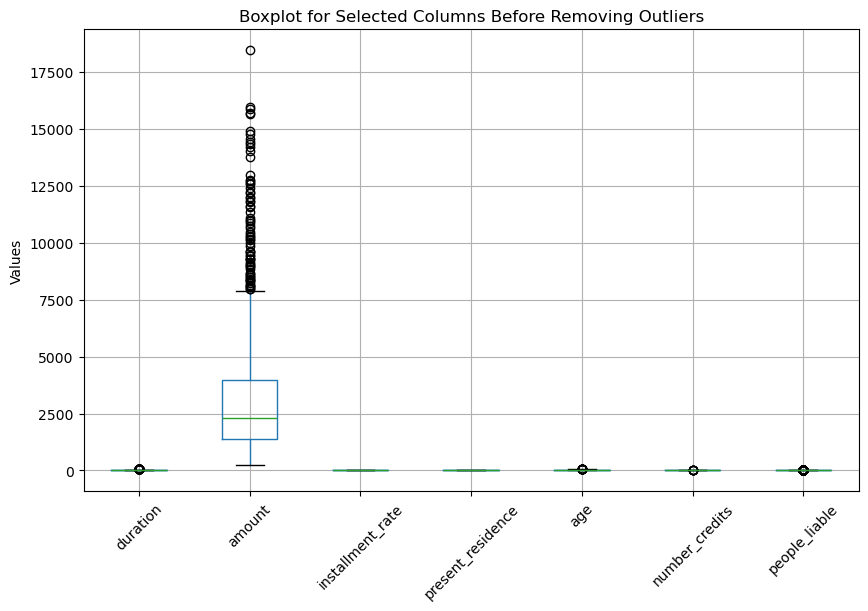

In [9]:

# Kolom-kolom yang akan dibuat boxplot
columns_to_plot = ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']

# Buat boxplot sebelum outlier handling
plt.figure(figsize=(10, 6))
X[columns_to_plot].boxplot()
plt.title('Boxplot for Selected Columns Before Removing Outliers')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()



In [10]:
# Kolom yang akan dihilangkan outliernya
column = 'amount'

# Hitung kuartil pertama (Q1) dan kuartil ketiga (Q3)
Q1 = data[column].quantile(0.3)
Q3 = data[column].quantile(0.6)

# Hitung IQR (Interquartile Range)
IQR = Q3 - Q1

# Tentukan batas bawah dan batas atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter seluruh DataFrame untuk menghilangkan baris dengan outlier di kolom 'amount'
data_no_outliers = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Tampilkan hasil
print("Jumlah baris sebelum menghapus outlier:", len(data))
print("Jumlah baris setelah menghapus outlier:", len(data_no_outliers))

Jumlah baris sebelum menghapus outlier: 1000
Jumlah baris setelah menghapus outlier: 811


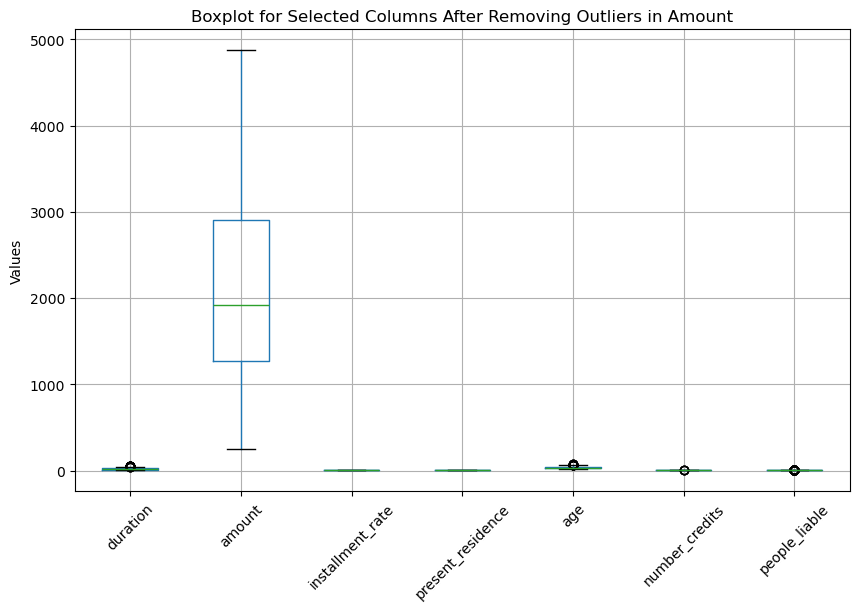

In [11]:
# Buat boxplot untuk kolom-kolom yang dipilih setelah menghilangkan outlier
plt.figure(figsize=(10, 6))
data_no_outliers[columns_to_plot].boxplot()
plt.title('Boxplot for Selected Columns After Removing Outliers in Amount')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Pisahkan fitur dan target setelah menghapus outlier
X_no_outliers = data_no_outliers.drop('credit_risk', axis=1)
y_no_outliers = data_no_outliers['credit_risk']

In [13]:
columns_to_normalize = ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']

# Inisialisasi MinMaxScaler
scaler = StandardScaler()

# Terapkan normalisasi hanya pada kolom yang diinginkan
df_normalized = X_no_outliers.copy()  # Membuat salinan DataFrame untuk menghindari perubahan langsung
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])

# Tampilkan hasil normalisasi
print("DataFrame setelah dinormalisasi:")

df_normalized

DataFrame setelah dinormalisasi:


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,gender,marital_status,...,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,0,-1.276630,1,3,-0.868950,4,1,0.837821,1,3,...,1.063264,2,2.807173,1,1,1.074686,1,-0.424847,1,1
2,3,-0.628323,1,9,-0.035211,0,3,-0.993642,1,3,...,0.157479,2,1.216184,1,1,-0.682512,3,2.353789,0,1
4,0,0.668292,2,1,2.459712,0,2,-0.077911,1,3,...,1.063264,3,1.569737,1,0,1.074686,1,2.353789,0,1
6,3,0.668292,3,7,0.629443,3,1,-0.077911,1,3,...,1.063264,0,1.569737,1,1,-0.682512,1,-0.424847,0,1
8,3,-0.628323,3,3,0.830907,1,3,-0.993642,1,0,...,1.063264,2,2.276843,1,1,-0.682512,3,-0.424847,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,-0.628323,3,7,-0.358993,0,3,-0.077911,0,1,...,1.063264,2,-0.374806,1,1,-0.682512,3,-0.424847,0,1
996,0,1.316600,3,2,1.548625,0,2,0.837821,1,0,...,1.063264,0,0.420689,1,1,-0.682512,0,-0.424847,1,1
997,3,-0.628323,3,3,-1.197229,0,1,0.837821,1,3,...,1.063264,1,0.243912,1,1,-0.682512,1,-0.424847,0,1
998,0,2.937368,3,3,-0.260959,0,2,0.837821,1,3,...,1.063264,3,-1.081912,1,0,-0.682512,1,-0.424847,1,1


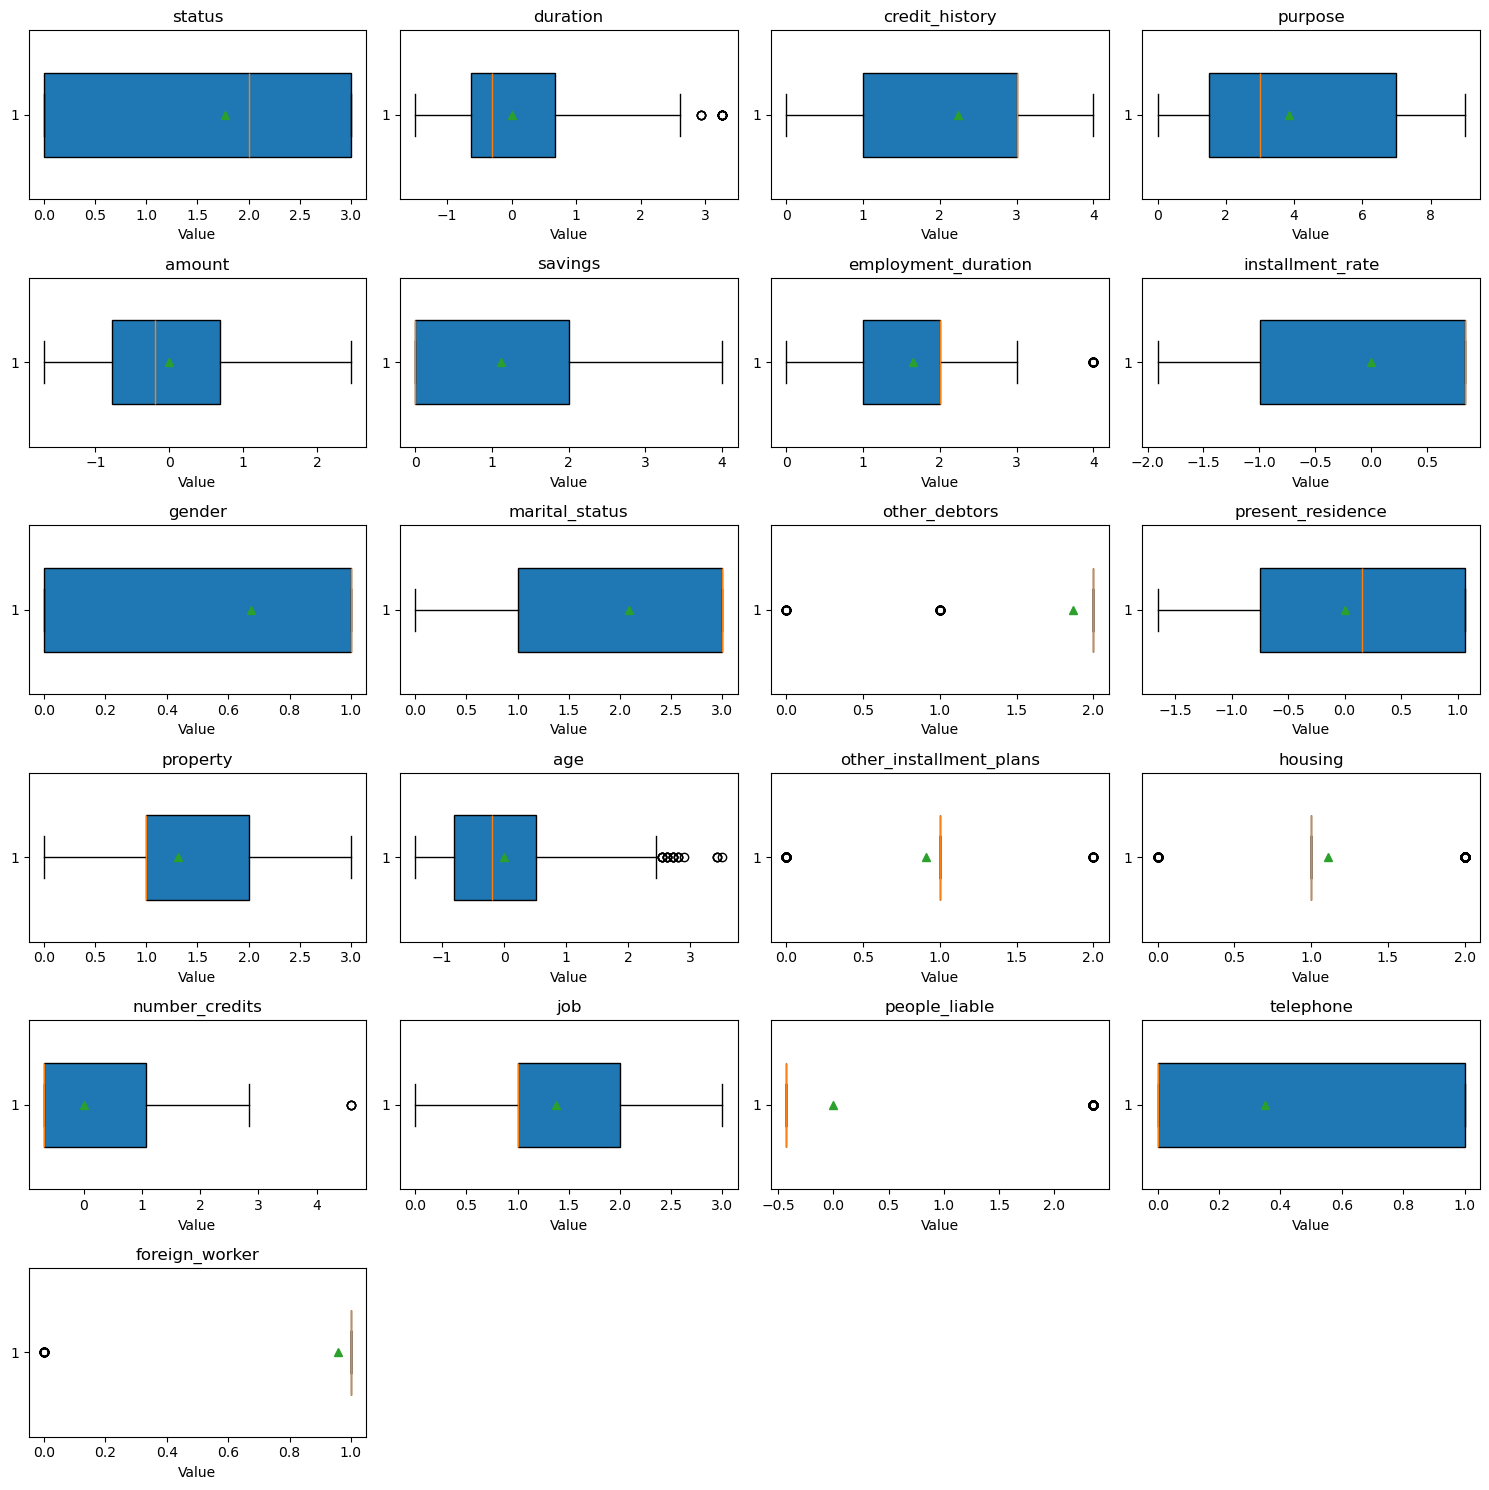

In [14]:
# Membuat figure dengan subplots (6 baris, 4 kolom)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Meratakan array 2D dari axes untuk iterasi yang lebih mudah
axes = axes.flatten()

# Iterasi setiap kolom dan membuat boxplot pada subplot
for i, column in enumerate(df_normalized.columns):
    axes[i].boxplot(df_normalized[column].values, vert=False, patch_artist=True, showmeans=True, widths=0.5)  # Horizontal boxplot with mean marker
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')

# Sembunyikan subplot yang tidak terpakai
for j in range(len(df_normalized.columns), len(axes)):
    fig.delaxes(axes[j])

# Sesuaikan layout untuk mencegah tumpang tindih judul
plt.tight_layout()

# Tampilkan plot
plt.show()

In [15]:
X = data.drop('credit_risk', axis=1)  
y = data['credit_risk']

In [16]:
# Reshape X for the CNN: (samples, time steps, features)
X_cnn = df_normalized.values.reshape(df_normalized.shape[0], df_normalized.shape[1], 1)

# Split data menjadi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_no_outliers, test_size=0.2, random_state=42)   

In [17]:
print(X_train.shape)
print(X_test.shape)

(648, 21, 1)
(163, 21, 1)


In [18]:
correlation_matrix = X.corrwith(y_train)
print("Korelasi fitur dengan target:")
print(correlation_matrix)

Korelasi fitur dengan target:
status                     0.273089
duration                  -0.194370
credit_history            -0.141855
purpose                   -0.043437
amount                    -0.015299
savings                    0.155698
employment_duration        0.055056
installment_rate          -0.095660
gender                     0.045856
marital_status             0.110323
other_debtors              0.022103
present_residence         -0.018970
property                   0.001026
age                        0.116326
other_installment_plans    0.043183
housing                   -0.025379
number_credits             0.058696
job                       -0.021867
people_liable             -0.019068
telephone                  0.094399
foreign_worker            -0.094506
dtype: float64


In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', target_accuracy=0.80):
        super(myCallback, self).__init__()
        self.monitor = monitor
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if np.greater_equal(current, self.target_accuracy):
            self.model.stop_training = True

# Membuat model CNN
model = Sequential([
    Reshape((21, 1), input_shape=(21, 1)),
    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Inisialisasi callback
my_early_stopping = myCallback(monitor='val_accuracy', target_accuracy=0.80)

# Latih model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[my_early_stopping])

Epoch 1/100
21/21 [==============================] - 2s 50ms/step - loss: 1.1410 - accuracy: 0.6157 - val_loss: 0.7181 - val_accuracy: 0.7117
Epoch 2/100
21/21 [==============================] - 0s 6ms/step - loss: 0.8592 - accuracy: 0.6836 - val_loss: 0.7549 - val_accuracy: 0.7055
Epoch 3/100
21/21 [==============================] - 0s 6ms/step - loss: 0.7812 - accuracy: 0.7130 - val_loss: 0.7552 - val_accuracy: 0.7178
Epoch 4/100
21/21 [==============================] - 0s 6ms/step - loss: 0.7280 - accuracy: 0.7083 - val_loss: 0.7525 - val_accuracy: 0.7178
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 0.6709 - accuracy: 0.7253 - val_loss: 0.7418 - val_accuracy: 0.7117
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 0.6524 - accuracy: 0.7392 - val_loss: 0.7453 - val_accuracy: 0.7301
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 0.6703 - accuracy: 0.7238 - val_loss: 0.7331 - val_accuracy: 0.7239
Epoch 8/100


6/6 [==============================] - 0s 2ms/step - loss: 0.5685 - accuracy: 0.8037
Test Loss: 0.569, Test Accuracy: 0.804


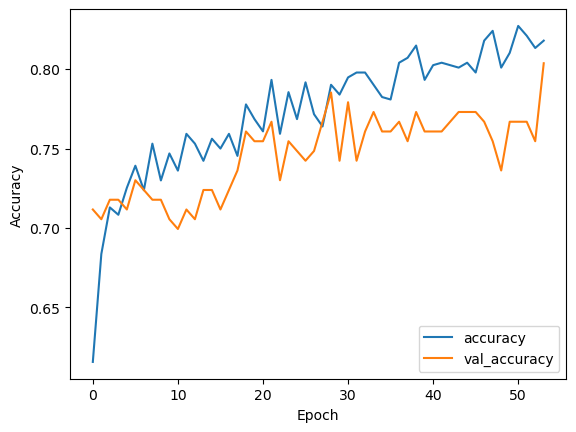

6/6 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.73      0.51      0.60        47
           1       0.82      0.92      0.87       116

    accuracy                           0.80       163
   macro avg       0.78      0.72      0.73       163
weighted avg       0.80      0.80      0.79       163



In [20]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Predict probabilities on test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

In [22]:
# Menyimpan model dalam format .keras
model.save('model_credit.keras')

INFO:tensorflow:Assets written to: model_credit.pkl\assets


INFO:tensorflow:Assets written to: model_credit.pkl\assets


In [23]:
with open('model_credit.pkl', 'wb') as file:
    pickle.dump(model, file)

INFO:tensorflow:Assets written to: ram://fc57e352-2eb3-4f1c-8e93-059722bf3406/assets


INFO:tensorflow:Assets written to: ram://fc57e352-2eb3-4f1c-8e93-059722bf3406/assets


In [23]:
# Simpan model
model.save('model.pb')



INFO:tensorflow:Assets written to: model.pb\assets


INFO:tensorflow:Assets written to: model.pb\assets


In [26]:
# Save the model
model.save('credit_risk_model.h5')
